
# 💎 Diamantanalys för Guldfynd

## Bakgrund
Guldfynd är ett företag specialiserat på smycken av guld och silver. Företaget överväger att utöka sitt sortiment till att även omfatta diamanter. Som dataanalytiker på IT-avdelningen har du fått i uppdrag att analysera ett tillgängligt diamant-dataset för att identifiera insikter som kan vägleda verksamhetens investeringsbeslut.

Syftet:
- Identifiera faktorer som påverkar diamantpriser.
- Förstå fördelningen av olika diamantkvaliteter.
- Skapa en grund för rekommendationer kring sortimentsstrategi.


## Innehållsförteckning
- Bakgrund
- Syftet
- Innehållsförteckning
- Datapreparation

-- Analysen --
- ❓ Biblotek + Code Cleaning
- 🔍 Gruppering
- 🔍 Visualiseringar

Visualiseringar visar:
1. Pris vs Vikt (Carat)
2. Pris per Färg
3. Pris per Klarhet
4. Pris per Slipkvalitet (Cut)
5. Fördelning: Cut
6. Fördelning: Clarity

- 📈 Prisfördelning (Pris x Antal) + (Antal Carat)
- 📊 Sammanfattande Insikter
- 📌 Executive Summary ( Förslag till Guldfynds ledning: )


## Datapreparation
Vi börjar med att ladda in datan, undersöka dess struktur och rensa bort saknade värden för att möjliggöra en pålitlig analys.

## ❓ Biblotek + Code Cleaning

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Läs in datan och ta bort rader med saknade värden
df = pd.read_excel('diamonds.xlsx')
df_clean = df.dropna().copy()

cols_to_check = ['carat', 'price', 'x', 'y', 'z']
cols_exist = [col for col in cols_to_check if col in df_clean.columns]

removed = {}

# Depth-avvikelse
if all(col in df_clean.columns for col in ['x', 'y', 'z', 'depth']):
    df_clean['depth_calc'] = (df_clean['z'] / ((df_clean['x'] + df_clean['y']) / 2)) * 100
    df_clean['depth_diff'] = abs(df_clean['depth_calc'] - df_clean['depth'])
    before = df_clean.shape[0]
    df_clean = df_clean[df_clean['depth_diff'] <= 1]
    removed[">1% avvikelse i depth"] = before - df_clean.shape[0]

# Längd–bredd-förhållande (endast om x och y finns)
if all(col in df_clean.columns for col in ['x', 'y']):
    df_clean['längd_bredd_kvot'] = df_clean['x'] / df_clean['y']
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean['längd_bredd_kvot'] >= 0.9) & (df_clean['längd_bredd_kvot'] <= 1.1)]
    removed['L/B-förhållande utanför 0.9–1.1'] = before - df_clean.shape[0]

# Ta bort rader med nollor i dimensioner (x, y, z)
if cols_exist:
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean[cols_exist] != 0).all(axis=1)]
    removed['Nollvärden i fysiska mått'] = before - df_clean.shape[0]

# Resultatsammanfattning
antal_före = len(df)
antal_efter = len(df_clean)
print(f"Antal borttagna rader: {antal_före - antal_efter}")
print(f"Antal rader kvar: {antal_efter}")
print("\nDetaljerad borttagningslogg:")
for reason, count in removed.items():
    print(f"- {reason}: {count} rader borttagna")

df_clean.head()

Antal borttagna rader: 176
Antal rader kvar: 53764

Detaljerad borttagningslogg:
- >1% avvikelse i depth: 100 rader borttagna
- L/B-förhållande utanför 0.9–1.1: 0 rader borttagna
- Nollvärden i fysiska mått: 0 rader borttagna


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,depth_calc,depth_diff,längd_bredd_kvot
0,1,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43,61.286255,0.213745,0.992462
1,2,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31,59.767141,0.032859,1.013021
2,3,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31,56.896552,0.003448,0.995086
4,5,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75,63.291139,0.008861,0.997701
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336.0,3.94,3.96,2.48,62.784810,0.015190,0.994949


## 🔍 Gruppering

In [10]:
# Gruppanalyser
avg_price_by_color = df_clean.groupby("color")["price"].mean().sort_index()
avg_price_by_clarity = df_clean.groupby("clarity")["price"].mean().sort_index()
avg_price_by_cut = df_clean.groupby("cut")["price"].mean().sort_index()
cut_mapping = {
        "Ideal": "Excellent",
        "Premium": "Very Good",
        "Very Good": "Good",
        "Good": "Fair",
        "Fair": "Poor"
    }
df_clean["cut_gia"] = df_clean["cut"].map(cut_mapping)
avg_price_by_cut_gia = df_clean.groupby("cut_gia")["price"].mean().sort_index()


In [11]:

# Diskretisera numeriska variabler i 3 grupper
depth_bins = pd.qcut(df_clean["depth"], q=3, labels=["Låg", "Mellan", "Hög"])
depth_counts = depth_bins.value_counts().sort_index()

table_bins = pd.qcut(df_clean["table"], q=3, labels=["Låg", "Mellan", "Hög"])
table_counts = table_bins.value_counts().sort_index()

carat_bins = pd.qcut(df_clean["carat"], q=3, labels=["Låg", "Mellan", "Hög"])
carat_counts = carat_bins.value_counts().sort_index()

cut_counts = df_clean["cut"].value_counts()
clarity_counts = df_clean["clarity"].value_counts()


## 🔎 Visualiseringar

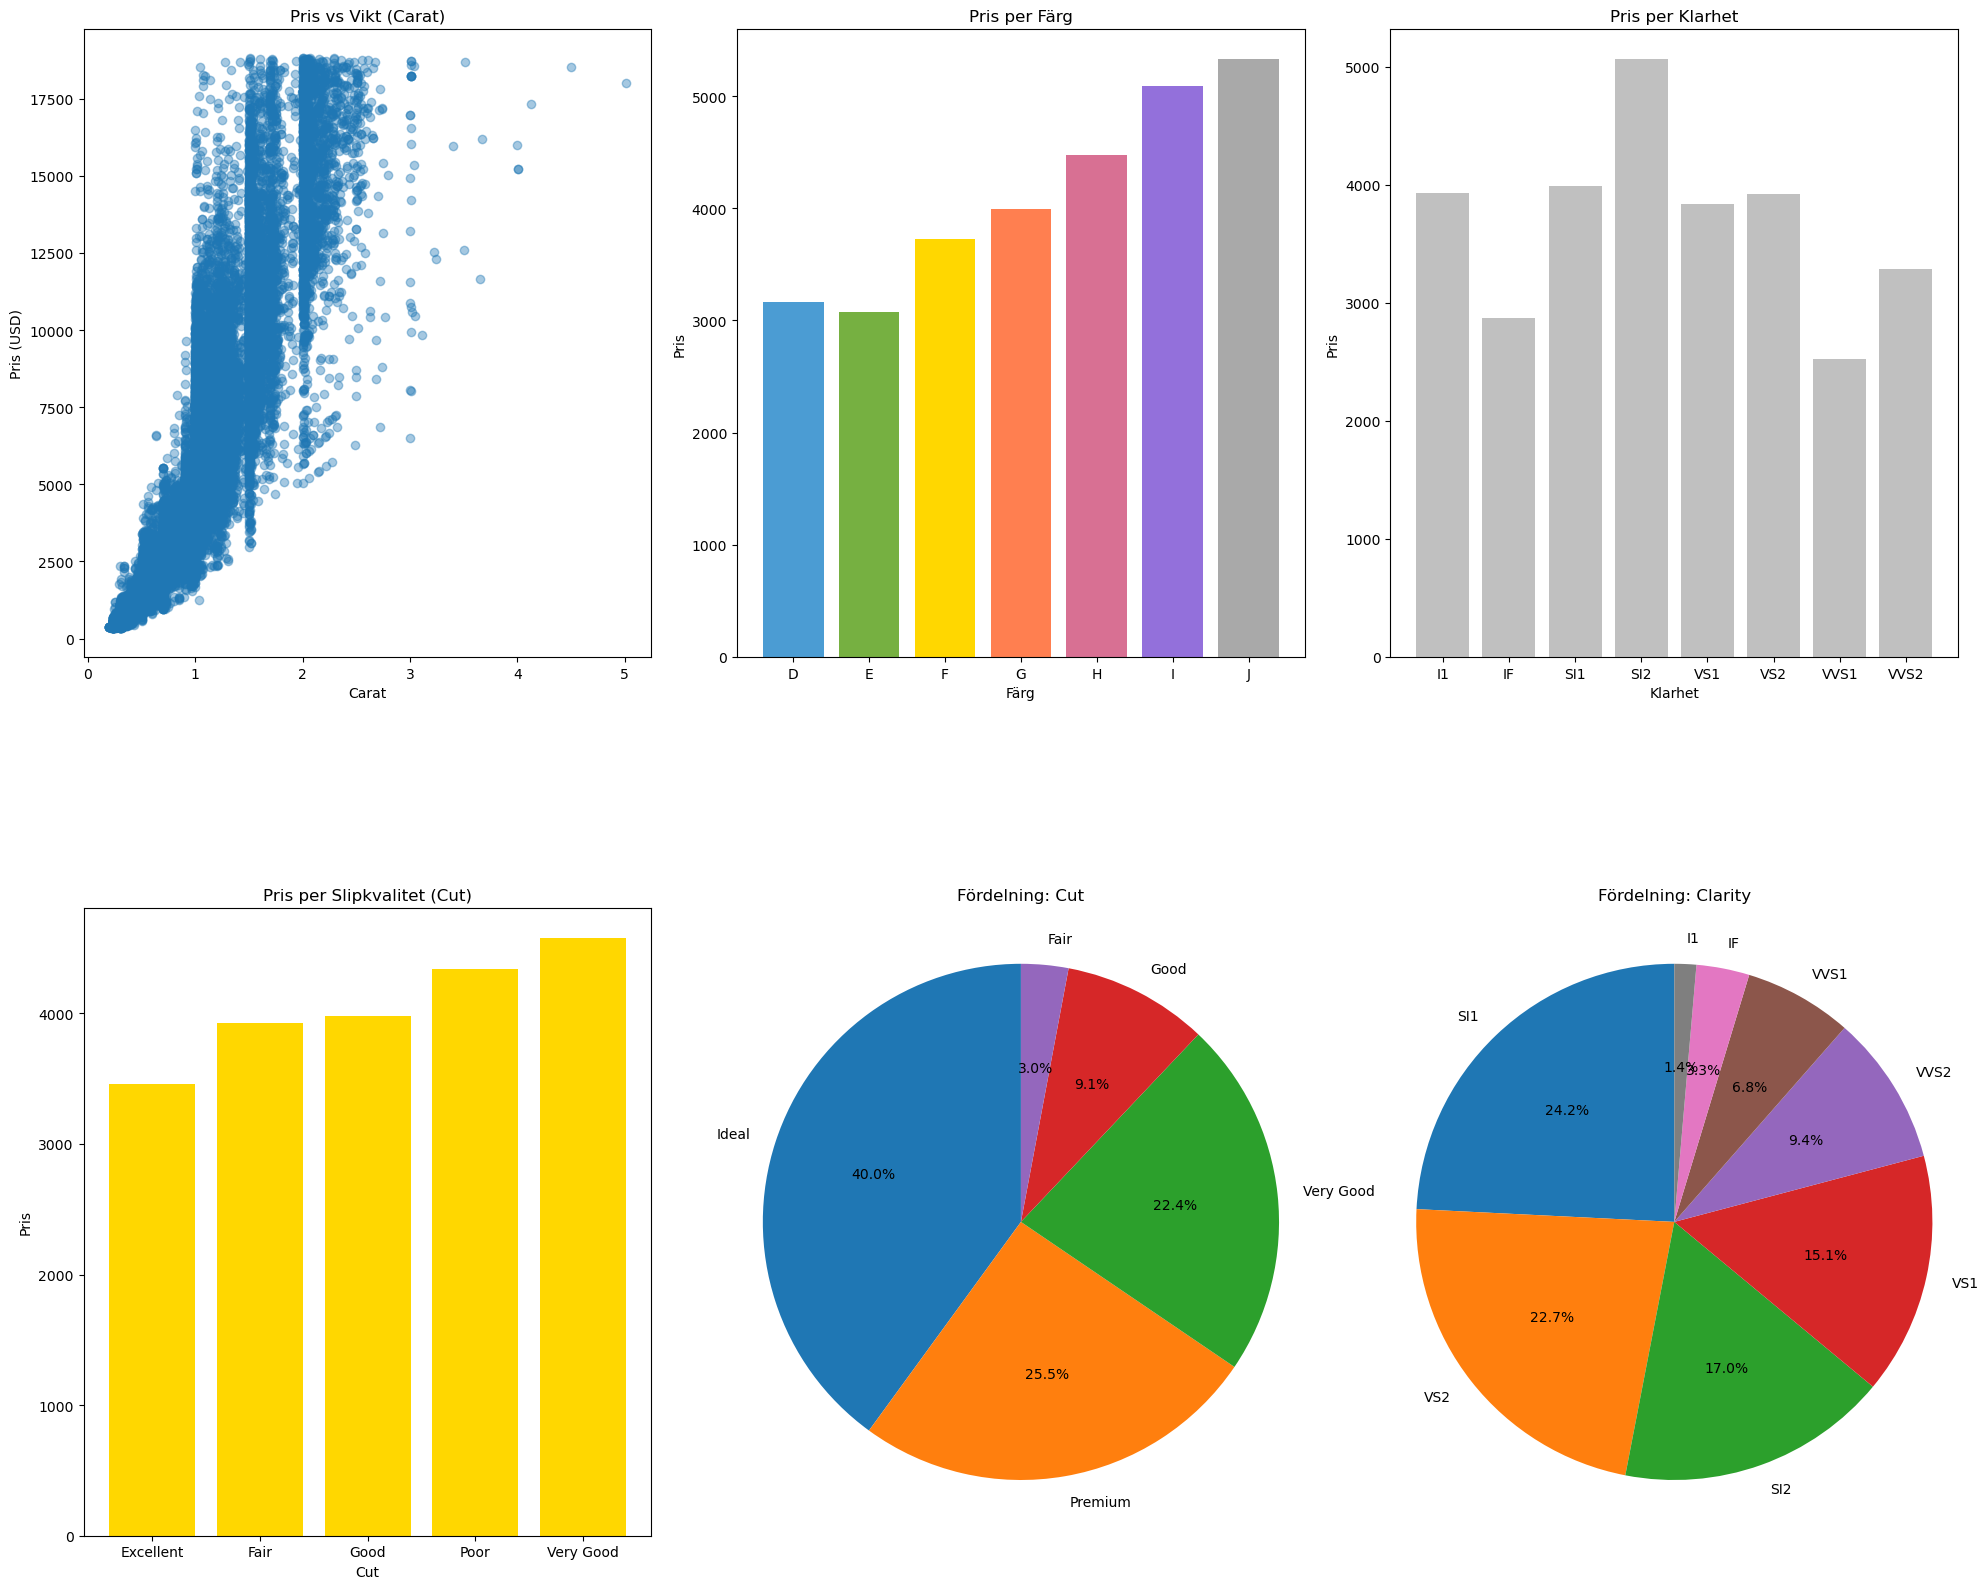

In [12]:
# Skapa subplot-grid: 3 rader x 3 kolumner
fig, axs = plt.subplots(2, 3, figsize=(20, 16))

axs[0, 0].scatter(df_clean["carat"], df_clean["price"], alpha=0.4)
axs[0, 0].set_title("Pris vs Vikt (Carat)")
axs[0, 0].set_xlabel("Carat")
axs[0, 0].set_ylabel("Pris (USD)")

color_map = {
    'D': '#4B9CD3',
    'E': '#76B041',
    'F': '#FFD700',
    'G': '#FF7F50',
    'H': '#D87093',
    'I': '#9370DB',
    'J': '#A9A9A9'
}

bar_colors = [color_map.get(color, 'gray') for color in avg_price_by_color.index]
axs[0, 1].bar(avg_price_by_color.index, avg_price_by_color.values, color=bar_colors)
axs[0, 1].set_title("Pris per Färg")
axs[0, 1].set_xlabel("Färg")
axs[0, 1].set_ylabel("Pris")

axs[0, 2].bar(avg_price_by_clarity.index, avg_price_by_clarity.values, color="silver")
axs[0, 2].set_title("Pris per Klarhet")
axs[0, 2].set_xlabel("Klarhet")
axs[0, 2].set_ylabel("Pris")

axs[1, 0].bar(avg_price_by_cut_gia.index, avg_price_by_cut_gia.values, color="gold")
axs[1, 0].set_title("Pris per Slipkvalitet (Cut)")
axs[1, 0].set_xlabel("Cut")
axs[1, 0].set_ylabel("Pris")

axs[1, 1].pie(cut_counts.values, labels=cut_counts.index, autopct='%1.1f%%', startangle=90)
axs[1, 1].set_title("Fördelning: Cut")
axs[1, 1].axis('equal')

axs[1, 2].pie(clarity_counts.values, labels=clarity_counts.index, autopct='%1.1f%%', startangle=90)
axs[1, 2].set_title("Fördelning: Clarity")
axs[1, 2].axis('equal')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

## 📈 Prisfördelning (Pris x Antal) + (Antal Carat)

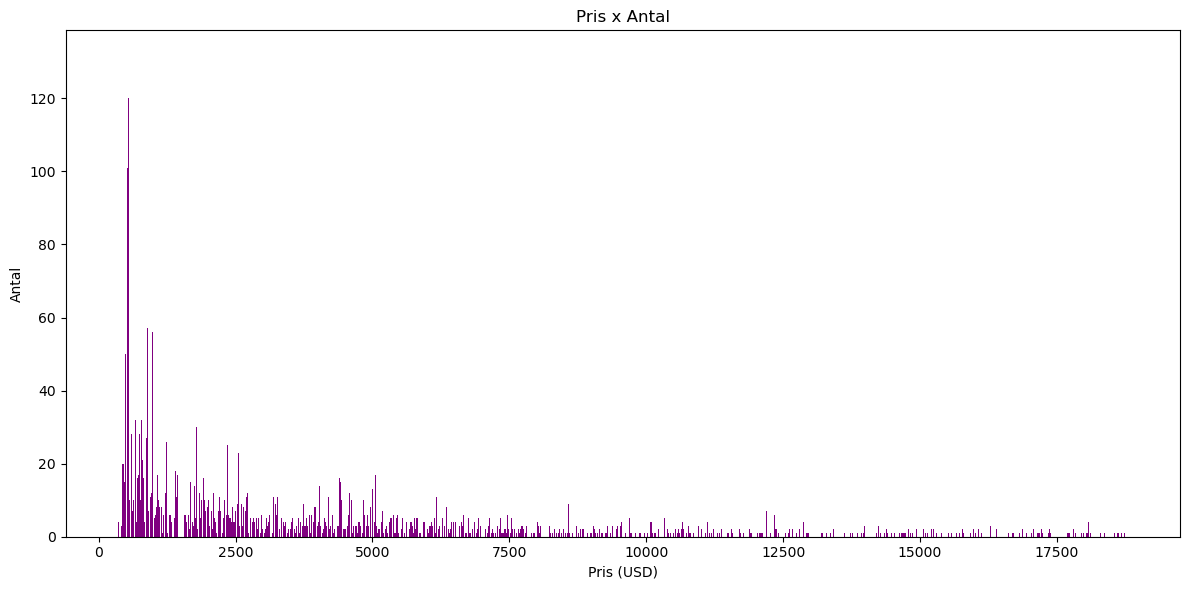

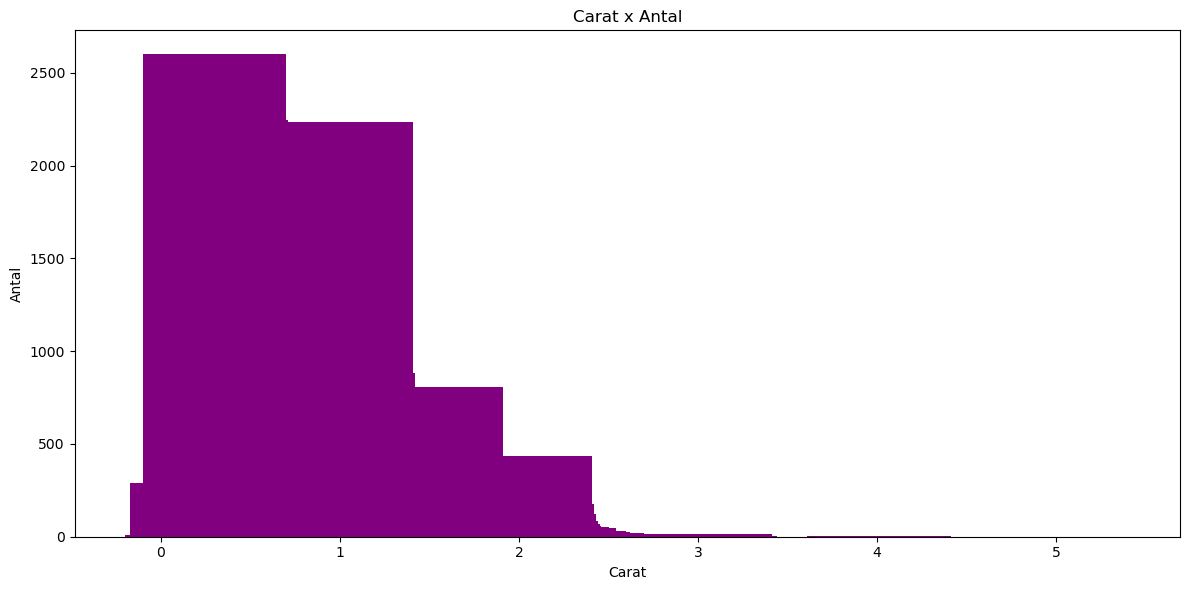

In [14]:
price_distribution = df_clean["price"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(price_distribution.index, price_distribution.values, color='purple')
plt.title("Pris x Antal")
plt.xlabel("Pris (USD)")
plt.ylabel("Antal")
plt.tight_layout()
plt.show()

price_distribution = df_clean["carat"].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(price_distribution.index, price_distribution.values, color='purple')
plt.title("Carat x Antal")
plt.xlabel("Carat")
plt.ylabel("Antal")
plt.tight_layout()
plt.show()


## 📊 Sammanfattande insikter

Efter att ha analyserat diamantdatasetet framträder följande centrala observationer:

1. **Carat har starkast koppling till priset**  
   Ju högre carat, desto högre pris – med ett tydligt icke-linjärt samband. Det finns ett särskilt prishopp runt 1.0 carat och uppåt.

2. **Slipkvalitet ("cut") har stor påverkan på priset**  
   Diamanter med högre slipkvalitet (t.ex. "Excellent", "Very Good") tenderar att ha högre pris än motsvarande stenar med sämre slip, även vid samma vikt.

3. **Färg och klarhet påverkar – men mer nyanserat**  
   Bättre färg (närmare D) och hög klarhet (t.ex. IF, VVS1) ger generellt högre priser, men variationen inom kategorierna är betydande.

4. **Större delen av diamanterna ligger i ett "mittsegment"**  
   De flesta diamanter har:
   - Vikt mellan **0.9–1.6 carat**
   - Mellannivåer för bord och djup
   - Medelhög klarhet och färg  
   Detta kan spegla både utbud och efterfrågan på marknaden.

5. **Prisspridning inom kategorier tyder på fler dolda faktorer**  
   Betydande variationer i pris finns även inom samma färg, klarhet eller vikt – vilket indikerar att exempelvis certifiering, fluorescens eller marknadsläge också spelar in.

(För dig som inte vet vad fluorescens är.. 
(AI Förklaring: Fluorescens i diamanter syftar på diamantens förmåga att avge ett synligt ljus (ofta blått) när den utsätts för UV-ljus.))


## 📌 Executive Summary

**Insikter:**
- Prisnivån på diamanter ökar kraftigt med ökad carat-vikt, vilket tyder på att vikt är en avgörande faktor för värdet.
- Slipkvalitet ("cut"), färg och klarhet påverkar priset i varierande grad. Särskilt slipkvaliteten har stark korrelation med prisnivåer.
- Majoriteten av diamanterna i datasetet ligger inom viktspannet 0.7–1.2 carat, vilket indikerar var efterfrågan är som störst på marknaden.
- Fördelningen av djup (depth) och bord (table) ligger också i ett tydligt mellansegment, vilket antyder industristandarder för proportioner.
- Betydande prisskillnader förekommer även inom samma kategori (t.ex. färg eller klarhet), vilket antyder att andra faktorer som certifiering, symmetri eller marknadsläge också påverkar priset.

**Rekommendationer:**
- Fokusera på diamanter mellan 0.7 – 1.2 carat, där marginalerna verkar vara bäst.
- Clarity VS2–SI1 och color G–H ger bäst balans mellan pris och kvalitet.
- "Excellent" och "Very Good" cut rekommenderas då de ofta erbjuder hög kvalitet till rimligt pris.
- "Very Good" cut ger ibland högt pris utan proportionellt högre värde.
- Undvik mycket stora diamanter (>2 carat) i första skedet – dessa är få och dyra.

Denna analys ger ett datadrivet underlag för produkturval, sortimentstrategi och prissättning vid en eventuell expansion till diamantförsäljning.